In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv', )
train = train.drop(['Unnamed: 0'], axis=1)
train.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1065,530,1108,532,1103,694,1108,834,1102,...,1066,240,1078,228,1052,229,1101,246,1030,248
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1062,528,1107,528,1103,694,1106,845,1102,...,1066,240,1080,228,1052,230,1101,246,1033,248
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1068,532,1105,531,1103,694,1106,848,1101,...,1066,240,1079,229,1051,229,1101,246,1033,249
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1068,532,1109,532,1103,694,1106,842,1101,...,1066,240,1078,229,1051,230,1101,246,1032,248
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1068,532,1105,532,1103,694,1103,839,1103,...,1066,240,1080,229,1051,231,1101,246,1034,248


In [4]:
train_paths = list(train['image'])

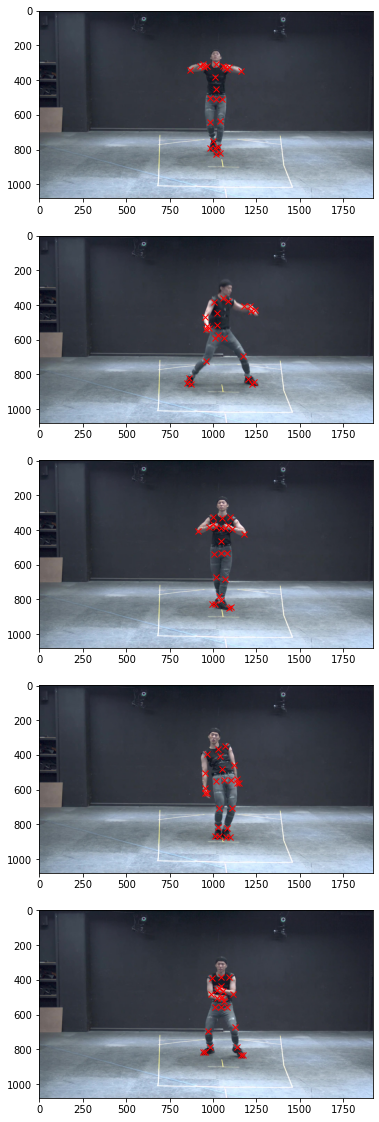

In [5]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [6]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['image'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:59].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([58])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [7]:
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [11]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58))

In [ ]:
from tensorflow.keras.applications import ResNet152V2
#backbone ResNet152V2
resnet152 = ResNet152V2(weights ='imagenet', include_top = False, 
                       input_shape = (270,480,3))

In [ ]:
# Callback 설정
earlystop = EarlyStopping(patience=7)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 2, 
                        factor = 0.85, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="./baseline_with_augmentation.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

callbacks = [earlystop, learning_rate_reduction, model_check]

In [ ]:
# layer 동결 해제(일부 or 전체)
for layer in resnet152.layers:
    layer.trainable = True

model = models.Sequential()
model.add(resnet152)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(48)) 
model.summary()

In [12]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])


In [13]:
model.fit(train_dataset,
                    epochs=5,
                    callbacks = callbacks)

Epoch 1/5
63/63 [==============================] - 460s 7s/step - loss: 55817.5625 - mae: 142.5496
Epoch 2/5
63/63 [==============================] - 437s 7s/step - loss: 9780.9619 - mae: 78.0790
Epoch 3/5
63/63 [==============================] - 436s 7s/step - loss: 8162.5371 - mae: 71.4863
Epoch 4/5
63/63 [==============================] - 436s 7s/step - loss: 7482.8472 - mae: 68.6660
Epoch 5/5
63/63 [==============================] - 460s 7s/step - loss: 7178.0635 - mae: 66.8235


In [14]:
test = pd.read_csv('test.csv', )
test = test.drop(['Unnamed: 0'], axis=1)
test.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1019,515,1046,512,1062,638,1049,742,1059,...,996,308,1008,293,984,292,1025,295,972,295
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1017,512,1042,511,1063,643,1049,745,1061,...,997,302,1010,284,986,285,1026,288,972,291
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1014,520,1041,518,1063,644,1049,748,1061,...,1000,296,1011,282,987,282,1027,287,975,289
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1012,523,1037,522,1068,647,1051,744,1060,...,1001,296,1013,281,989,282,1030,289,976,291
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1011,523,1052,520,1062,653,1042,763,1065,...,1002,297,1014,285,989,285,1032,295,975,297


In [15]:
test_paths = test['image']

In [16]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 100/100 [00:01<00:00, 80.57it/s]


In [17]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([100, 180, 320, 3])

In [18]:
pred=model.predict(X_test)

In [20]:
predict = pd.DataFrame(pred, columns = ["center_hip_x", "center_hip_y", "left_hip_x", "left_hip_y", "left_knee_x", "left_knee_y", "left_ankle_x", "left_ankle_y", "left_bigtoe_X", "left_bigtoe_y",
                "left_littletoe_x", "left_littletoe_y", "right_hip_x", "right_hip_y", "right_knee_x", "right_knee_y", "right_ankle_x", "right_ankle_y", "right_bigtoe_x", "right_bigtoe_y",
                "right_littletoe_x", "right_littletoe_y", "navel_x", "navel_y", "chest_x", "chest_y", "neck_x", "neck_y", "left_shoulder_x", "left_shoulder_y", "left_elbow_x", "left_elbow_y",
                "left_wrist_x", "left_wrist_y", "left_palm_thumb_x", "left_palm_thumb_y", "left_palm_pinky_x", "left_palm_pinky_y", "right_shoulder_x", "right_shoulder_y", "right_elbow_x", "right_elbow_y",
                "right_wrist_x", "right_wrist_y", "right_palm_thumb_x", "right_palm_thumb_y", "right_palm_pinky_x", "right_palm_pinky_y", "nose_x", "nose_y", "left_eye_x", "left_eye_y",
                "right_eye_x", "right_eye_y", "left_ear_x", "left_ear_y", "right_ear_x", "right_ear_y"])

predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,1434.953369,740.782288,1470.920776,740.001465,1481.102661,898.022095,1456.027588,1067.683716,1453.098877,1101.548584,...,1460.746704,467.636078,1493.765625,446.577972,1445.386475,471.036560,1471.663330,433.827759,1387.039062,433.144775
1,1387.634888,709.683899,1424.281006,707.413147,1432.392090,861.666626,1406.686768,1019.235657,1400.438965,1061.976807,...,1407.085083,451.034821,1441.365723,439.103333,1392.435181,457.171173,1420.722168,422.626373,1341.554688,419.610992
2,1370.190918,699.231323,1400.046631,696.045593,1412.685059,852.783447,1394.502686,998.229187,1381.039185,1044.276245,...,1380.503296,460.705139,1413.885986,453.355255,1370.611572,457.391571,1397.711182,428.533813,1316.087769,424.539215
3,1364.471313,692.781128,1391.145508,684.121460,1401.479492,842.629456,1383.692017,988.679199,1360.197754,1034.825928,...,1370.640991,445.213043,1408.964600,443.917847,1364.046631,449.151550,1388.432495,421.425537,1319.393433,416.099396
4,1360.975220,695.714783,1382.367310,684.739807,1400.232422,845.486328,1385.632812,981.848572,1359.628174,1025.601074,...,1361.746216,452.927979,1401.150024,457.321533,1358.984619,454.713501,1380.657227,430.238647,1309.068970,423.737579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1428.574829,816.307861,1469.517090,806.594421,1514.479248,911.195923,1504.045654,1088.494873,1515.205200,1131.058594,...,1456.725586,533.465027,1491.124634,512.172546,1431.380371,561.037842,1457.607666,496.186035,1361.562134,514.926392
96,1423.647095,798.879028,1459.188843,788.085449,1491.687256,903.037842,1477.125732,1076.770630,1480.315918,1125.965332,...,1441.121704,524.340515,1470.794678,503.177582,1421.146484,543.947327,1446.487061,485.010773,1352.530151,500.071350
97,1421.256714,783.931885,1446.762695,770.235657,1477.116943,900.375488,1459.861328,1067.284424,1453.310303,1119.501709,...,1428.608154,516.068420,1455.630249,496.712769,1415.666504,527.728882,1440.176025,477.724548,1350.448120,486.409454
98,1414.180298,768.767517,1436.634644,753.100769,1466.062622,896.464783,1444.372070,1059.470337,1437.786255,1111.193237,...,1415.612183,497.716705,1440.657471,477.328613,1405.360474,503.690399,1430.810547,462.555664,1345.472534,465.219666


In [21]:
my_test = pd.concat([test['image'], predict], axis=1)

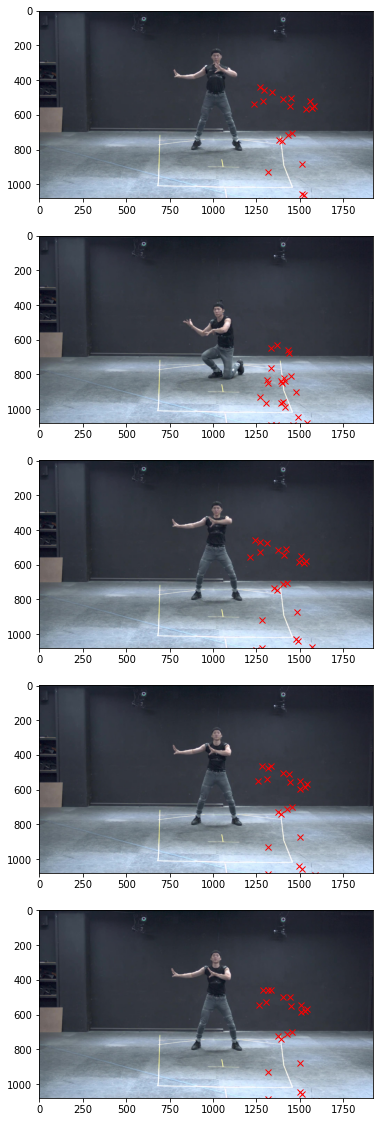

In [23]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1